In [1]:
from plantcv import plantcv as pcv
pcv.params.debug = "plot"


In [ ]:
# Updated text params so that labels are readable 
pcv.params.text_size = 50
pcv.params.text_thickness = 35

In [ ]:
# Change plot size to be larger to better see each colorspace 
import matplotlib
%matplotlib inline
matplotlib.rcParams["figure.figsize"] = [8,8]

In [ ]:
img, path, filename = pcv.readimage(filename="camelina_seeds.jpg")


In [ ]:
# Visualize all colorspaces to help determine a thresholding channel 
colorspaces = pcv.visualize.colorspaces(img)

In [ ]:
l = pcv.rgb2gray_lab(rgb_img=img, channel="l")


In [ ]:
l_thresh = pcv.threshold.binary(gray_img=l, threshold=120, max_value=255, object_type="dark")


In [ ]:
plant_obj, plant_hier = pcv.find_objects(img=img, mask=l_thresh)


In [ ]:
roi_contour, roi_hierarchy = pcv.roi.rectangle(img=img, x=0, y=900, h=2168, w=3500)


In [ ]:
objects, hier, seed_mask, obj_area = pcv.roi_objects(img=img, roi_contour=roi_contour, roi_hierarchy=roi_hierarchy,
                                                     object_contour=plant_obj, obj_hierarchy=plant_hier, roi_type='partial')

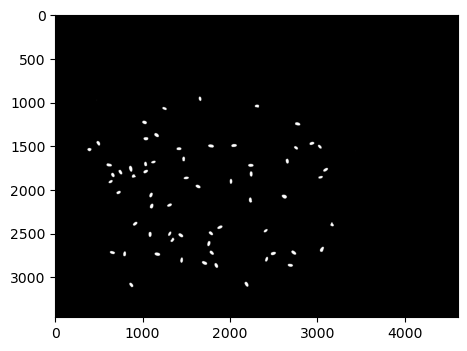

In [3]:
seed_mask, path, filename = pcv.readimage(filename="seed_mask.png")

# Detect disks 

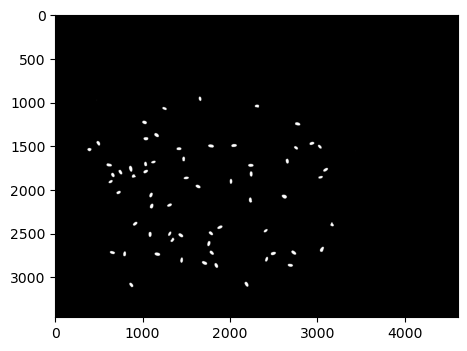

In [4]:
discs_mask, discs_coor = pcv.detect_discs(bin_img=seed_mask, ecc_thresh=0.9)

In [5]:
print(discs_coor)

[(958, 1658), (973, 477), (975, 458), (1041, 2310), (1069, 1252), (1228, 1023), (1245, 2774), (1373, 1161), (1415, 1039), (1466, 495), (1469, 2936), (1493, 2047), (1498, 1784), (1506, 3027), (1519, 2756), (1529, 1417), (1539, 393), (1554, 3435), (1647, 1470), (1671, 2655), (1682, 1125), (1705, 1035), (1716, 618), (1719, 2239), (1758, 866), (1770, 3093), (1797, 748), (1790, 1036), (1818, 2242), (1830, 661), (1843, 899), (1856, 3036), (1864, 1500), (1903, 2012), (1906, 636), (1962, 1635), (2030, 726), (2059, 1097), (2077, 2622), (2117, 2234), (2175, 1309), (2186, 1105), (2388, 916), (2398, 3167), (2428, 1885), (2468, 2408), (2497, 1782), (2502, 1311), (2509, 1086), (2520, 1438), (2574, 1342), (2615, 1758), (2682, 3051), (2718, 2729), (2720, 1791), (2718, 656), (2733, 796), (2728, 2495), (2736, 1170), (2794, 2419), (2804, 1447), (2837, 1709), (2865, 1844), (2863, 2690), (3080, 2190), (3088, 872)]


# Click count 

In [ ]:
seed_counter = pcv.visualize.ClickCount(img)

In [ ]:
seed_counter.import_coords(discs_coor, label="total")

In [ ]:
seed_counter.view(label="total", color="c", view_all=True)
# Notice one rogue object detected on the right hand side and two 
# at the upper left that need to be deselected. No seeds are 
# unaccounted for which is good! 

In [ ]:
seed_counter.save_coords(coord_file="example_seed_coords.json")